# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [68]:
from matplotlib import widgets
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import io
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout

### Create a dataset

Mount Google Drive

In [49]:
from google.colab import drive
drive.mount('/content/drive')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  139k    0  139k    0     0   438k      0 --:--:-- --:--:-- --:--:--  438k


Unzip dataset

In [57]:
!unzip -q drive/MyDrive/archive.zip

replace Drug Vision/Data Combined/Alaxan/00000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Drug Vision/Data Combined/Alaxan/00000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Drug Vision/Data Combined/Alaxan/00000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace Drug Vision/Data Combined/Alaxan/00000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace Drug Vision/Data Combined/Alaxan/00000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

80 - 20 split

In [19]:
data_dir = "Drug Vision/Data Combined"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


Verify classes

In [21]:
class_names = train_ds.class_names
print(class_names)

['Alaxan', 'Bactidol', 'Bioflu', 'Biogesic', 'DayZinc', 'Decolgen', 'Fish Oil', 'Kremil S', 'Medicol', 'Neozep']


## Visualize the data

Here are the first nine images from the training dataset:

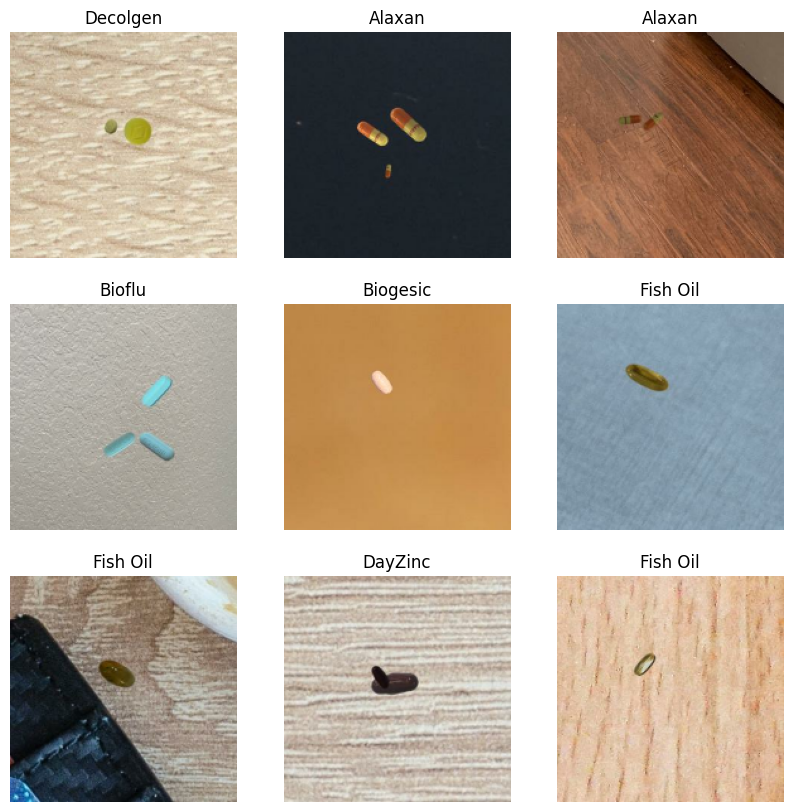

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Autotune chache and prefetch

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

Rescale RGB into 1


In [26]:
normalization_layer = layers.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.72156864


## A basic Keras model


In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile Model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
250/250 [==============================] - 21s 36ms/step - loss: 2.1733 - accuracy: 0.1730 - val_loss: 1.9728 - val_accuracy: 0.2460
Epoch 2/10
250/250 [==============================] - 5s 20ms/step - loss: 1.8246 - accuracy: 0.3105 - val_loss: 1.6246 - val_accuracy: 0.4025
Epoch 3/10
250/250 [==============================] - 5s 21ms/step - loss: 1.2536 - accuracy: 0.5480 - val_loss: 1.1485 - val_accuracy: 0.5830
Epoch 4/10
250/250 [==============================] - 5s 21ms/step - loss: 0.7939 - accuracy: 0.7311 - val_loss: 0.9175 - val_accuracy: 0.6735
Epoch 5/10
250/250 [==============================] - 5s 20ms/step - loss: 0.5135 - accuracy: 0.8317 - val_loss: 0.9600 - val_accuracy: 0.6965
Epoch 6/10
250/250 [==============================] - 5s 21ms/step - loss: 0.3289 - accuracy: 0.8972 - val_loss: 1.0711 - val_accuracy: 0.7065
Epoch 7/10
250/250 [==============================] - 6s 23ms/step - loss: 0.2106 - accuracy: 0.9352 - val_loss: 1.0582 - val_accuracy: 0.713

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

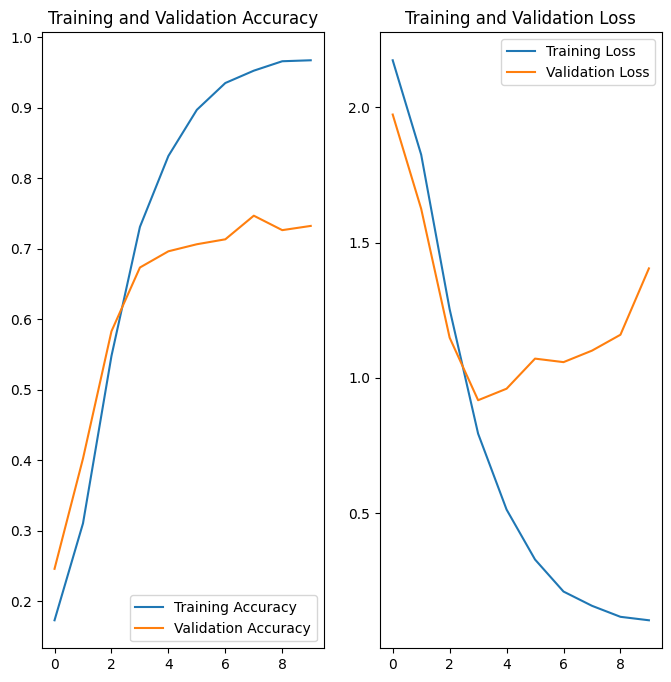

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting Prevention


## Data augmentation

Data argumentation by changing orietation 

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

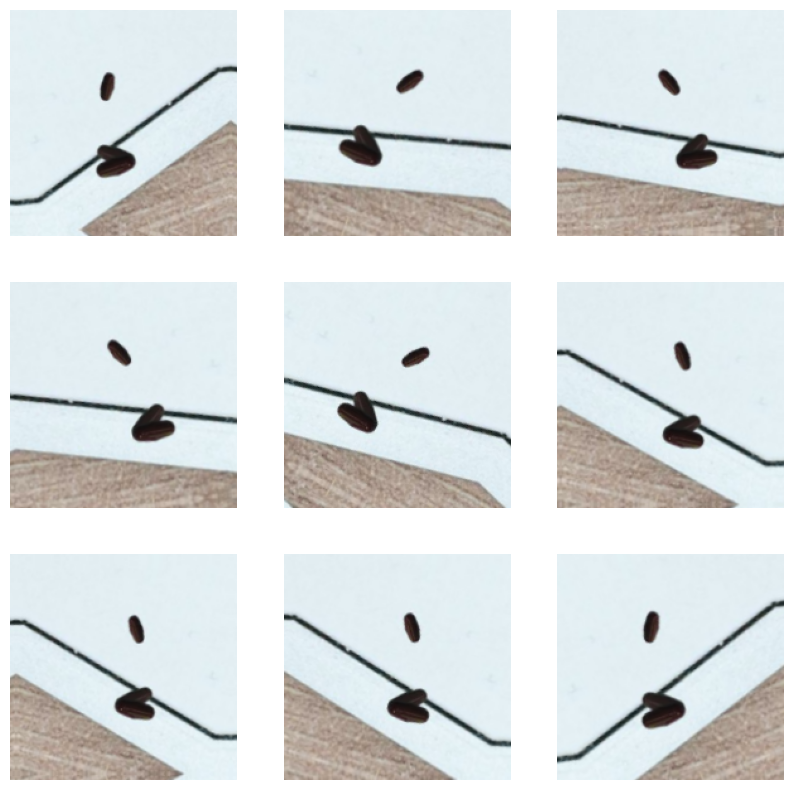

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout
Adding Dropout

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [38]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
250/250 [==============================] - 11s 30ms/step - loss: 2.3082 - accuracy: 0.0962 - val_loss: 2.3032 - val_accuracy: 0.0910
Epoch 2/15
250/250 [==============================] - 7s 29ms/step - loss: 2.1903 - accuracy: 0.1748 - val_loss: 1.9901 - val_accuracy: 0.2450
Epoch 3/15
250/250 [==============================] - 8s 31ms/step - loss: 1.8574 - accuracy: 0.3187 - val_loss: 1.5217 - val_accuracy: 0.4485
Epoch 4/15
250/250 [==============================] - 8s 32ms/step - loss: 1.3937 - accuracy: 0.4789 - val_loss: 1.1416 - val_accuracy: 0.5980
Epoch 5/15
250/250 [==============================] - 7s 29ms/step - loss: 0.9886 - accuracy: 0.6491 - val_loss: 0.8392 - val_accuracy: 0.7160
Epoch 6/15
250/250 [==============================] - 7s 30ms/step - loss: 0.7283 - accuracy: 0.7536 - val_loss: 0.6307 - val_accuracy: 0.7980
Epoch 7/15
250/250 [==============================] - 8s 31ms/step - loss: 0.6048 - accuracy: 0.8010 - val_loss: 0.5080 - val_accuracy: 0.838

Visualise

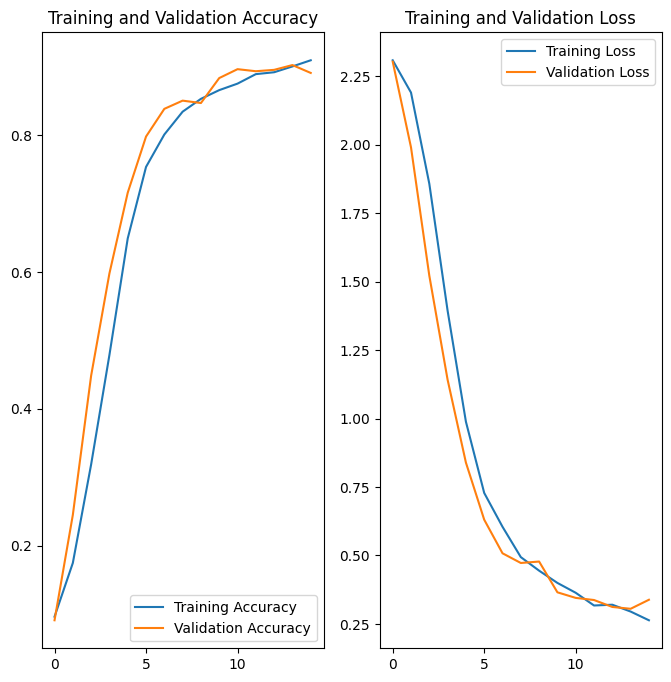

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Predictions

In [40]:
# sunflower_url = ""
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
sunflower_path = "drive/MyDrive/neozep.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 205ms/step
This image most likely belongs to Neozep with a 98.18 percent confidence.


In [44]:
model.save('model.h5')
tf.keras.models.load_model('model.h5').summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#Implementation


In [106]:
text = widgets.HTML(
    value="<h1>Pill Checker </h1>",
)

uploaded_file = widgets.FileUpload(
    accept='.jpg',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)


button = widgets.Button(
    description='Check',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)
# TwoByTwoLayout(top_left=uploaded_file,
#                top_right=button)
display(button,uploaded_file)
def on_button_clicked(b): 
    display(text)
    uploaded_filename = list(uploaded_file.value.keys())[0]
    uploaded_data = uploaded_file.value[uploaded_filename]['content']
    
    # Save the uploaded image
    with open(uploaded_filename, 'wb') as f:
        f.write(uploaded_data)
    
button.on_click(on_button_clicked)


Button(description='Check', icon='check', style=ButtonStyle(), tooltip='Description')

FileUpload(value={}, accept='.jpg', description='Upload')

HTML(value='<h1>Pill Checker </h1>')